In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("omkargurav/face-mask-dataset")

print("Path to dataset files:", path)

Using Colab cache for faster access to the 'face-mask-dataset' dataset.
Path to dataset files: /kaggle/input/face-mask-dataset


In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
DIRECTORY = r"/kaggle/input/face-mask-dataset/data"
CATEGORIES = ["with_mask", "without_mask"]

In [ ]:
DIRECTORY

'/kaggle/input/face-mask-dataset/data'

In [ ]:
import cv2

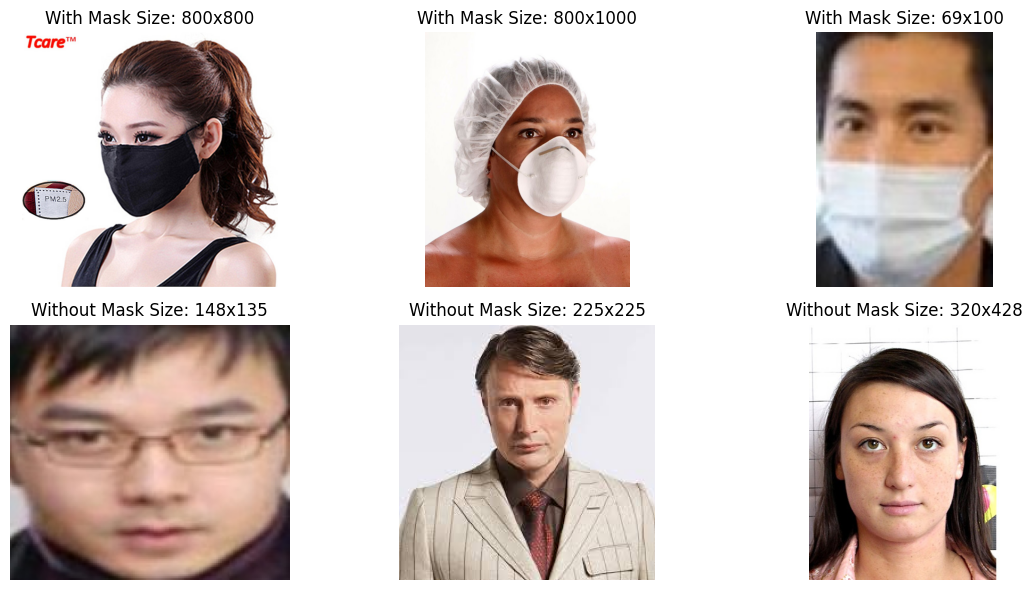

With Mask: 3725 image
Without Mask: 3828 image


In [ ]:
classes = {
    "With Mask": "/kaggle/input/face-mask-dataset/data/with_mask",
    "Without Mask": "/kaggle/input/face-mask-dataset/data/without_mask"
}

plt.figure(figsize=(12, 6))

index = 1
for label, folder in classes.items():
    img_files = os.listdir(folder)[:3]
    for img_name in img_files:
        img_path = os.path.join(folder, img_name)
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        height, width, channels = img.shape


        plt.subplot(2, 3, index)
        plt.imshow(img)
        plt.title(f"{label} Size: {width}x{height}")
        plt.axis("off")
        index += 1

plt.tight_layout()
plt.show()


for label, folder in classes.items():
    count = len(os.listdir(folder))
    print(f"{label}: {count} image")


In [ ]:
split_classes = {
    "Train With Mask": "/kaggle/input/face-mask-dataset/data/with_mask",
    "Train Without Mask": "/kaggle/input/face-mask-dataset/data/without_mask",
}
for label, folder in split_classes.items():
    count = len(os.listdir(folder))
    print(f"{label}: {count} image")

Train With Mask: 3725 image
Train Without Mask: 3828 image


In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img, img_to_array, ImageDataGenerator
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2, preprocess_input
from tensorflow.keras.layers import AveragePooling2D,GlobalAveragePooling2D, Dropout, Flatten, Dense, Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from imutils import paths
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

In [ ]:
data, labels = [], []
IMG_SIZE = 128
for category in CATEGORIES:
    path = os.path.join(DIRECTORY, category)
    for img in os.listdir(path):
        img_path = os.path.join(path, img)
        image = load_img(img_path, target_size=(IMG_SIZE, IMG_SIZE))
        image = img_to_array(image)
        image = preprocess_input(image)

        data.append(image)
        labels.append(category)

/usr/local/lib/python3.12/dist-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


In [ ]:
data[0]


array([[[1.        , 1.        , 1.        ],
        [1.        , 1.        , 1.        ],
        [1.        , 1.        , 1.        ],
        ...,
        [1.        , 1.        , 1.        ],
        [1.        , 1.        , 1.        ],
        [1.        , 1.        , 1.        ]],

       [[1.        , 1.        , 1.        ],
        [0.99215686, 0.99215686, 0.99215686],
        [0.9764706 , 0.94509804, 0.9529412 ],
        ...,
        [1.        , 1.        , 1.        ],
        [1.        , 1.        , 1.        ],
        [1.        , 1.        , 1.        ]],

       [[1.        , 1.        , 1.        ],
        [0.99215686, 0.99215686, 0.99215686],
        [0.78039217, 0.11372554, 0.1686275 ],
        ...,
        [1.        , 1.        , 1.        ],
        [1.        , 1.        , 1.        ],
        [1.        , 1.        , 1.        ]],

       ...,

       [[1.        , 1.        , 1.        ],
        [1.        , 1.        , 1.        ],
        [1.        , 1

In [ ]:
label

'Train Without Mask'

In [ ]:
data = np.array(data, dtype="float32")
labels = np.array(labels)


In [ ]:
labels

array(['with_mask', 'with_mask', 'with_mask', ..., 'without_mask',
       'without_mask', 'without_mask'], dtype='<U12')

In [ ]:
lb = LabelBinarizer()
labels = lb.fit_transform(labels)
labels = to_categorical(labels)

In [ ]:
labels

array([[1., 0.],
       [1., 0.],
       [1., 0.],
       ...,
       [0., 1.],
       [0., 1.],
       [0., 1.]])

In [ ]:
(trainX, testX, trainY, testY) = train_test_split(
    data, labels, test_size=0.2, stratify=labels, random_state=42
)

In [ ]:
aug = ImageDataGenerator(
    rotation_range=20,
    zoom_range=0.15,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.15,
    horizontal_flip=True,
    fill_mode="nearest"
)

In [ ]:
baseModel = MobileNetV2(
    weights="imagenet",
    include_top=False,
    input_tensor=Input(shape=(IMG_SIZE, IMG_SIZE, 3))
)


/tmp/ipython-input-1925292318.py:1: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  baseModel = MobileNetV2(


In [ ]:
headModel = baseModel.output
headModel = GlobalAveragePooling2D()(headModel)   # adaptive pooling
headModel = Dense(128, activation="relu")(headModel)
headModel = Dropout(0.5)(headModel)
headModel = Dense(len(CATEGORIES), activation="softmax")(headModel)

In [ ]:
model = Model(inputs=baseModel.input, outputs=headModel)

In [ ]:
for layer in baseModel.layers:
    layer.trainable = False

In [ ]:
INIT_LR = 0.0001     # Learning rate
EPOCHS = 20        # Training epochs
BS = 16            # Batch size

In [ ]:
opt = Adam(learning_rate=INIT_LR, decay=INIT_LR / EPOCHS)
model.compile(loss="binary_crossentropy", optimizer=opt, metrics=["accuracy"])

/usr/local/lib/python3.12/dist-packages/keras/src/optimizers/base_optimizer.py:86: UserWarning: Argument `decay` is no longer supported and will be ignored.
  warnings.warn(


In [ ]:
H = model.fit(
    aug.flow(trainX, trainY, batch_size=BS),
    steps_per_epoch=len(trainX) // BS,
    validation_data=(testX, testY),
    validation_steps=len(testX) // BS,
    epochs=EPOCHS
)

Epoch 1/20


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


377/377 ━━━━━━━━━━━━━━━━━━━━ 76s 157ms/step - accuracy: 0.8268 - loss: 0.4810 - val_accuracy: 0.9841 - val_loss: 0.0628
Epoch 2/20
  1/377 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step - accuracy: 1.0000 - loss: 0.0290

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:116: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


377/377 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 1.0000 - loss: 0.0290 - val_accuracy: 0.9841 - val_loss: 0.0627
Epoch 3/20
377/377 ━━━━━━━━━━━━━━━━━━━━ 36s 71ms/step - accuracy: 0.9610 - loss: 0.1170 - val_accuracy: 0.9795 - val_loss: 0.0538
Epoch 4/20
377/377 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 1.0000 - loss: 0.0623 - val_accuracy: 0.9788 - val_loss: 0.0541
Epoch 5/20
377/377 ━━━━━━━━━━━━━━━━━━━━ 40s 71ms/step - accuracy: 0.9681 - loss: 0.0966 - val_accuracy: 0.9848 - val_loss: 0.0467
Epoch 6/20
377/377 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 1.0000 - loss: 0.0568 - val_accuracy: 0.9854 - val_loss: 0.0467
Epoch 7/20
377/377 ━━━━━━━━━━━━━━━━━━━━ 26s 69ms/step - accuracy: 0.9746 - loss: 0.0761 - val_accuracy: 0.9854 - val_loss: 0.0448
Epoch 8/20
377/377 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 1.0000 - loss: 0.0165 - val_accuracy: 0.9854 - val_loss: 0.0447
Epoch 9/20
377/377 ━━━━━━━━━━━━━━━━━━━━ 26s 69ms/step - accuracy: 0.9814 - loss: 0.0619 - val_accuracy: 0.988

In [ ]:
predIdxs = model.predict(testX, batch_size=BS)
predIdxs = np.argmax(predIdxs, axis=1)

print(classification_report(testY.argmax(axis=1), predIdxs, target_names=lb.classes_))

95/95 ━━━━━━━━━━━━━━━━━━━━ 16s 115ms/step
              precision    recall  f1-score   support

   with_mask       0.99      0.97      0.98       745
without_mask       0.98      0.99      0.98       766

    accuracy                           0.98      1511
   macro avg       0.98      0.98      0.98      1511
weighted avg       0.98      0.98      0.98      1511



In [ ]:
model.save("mask_detector.keras")


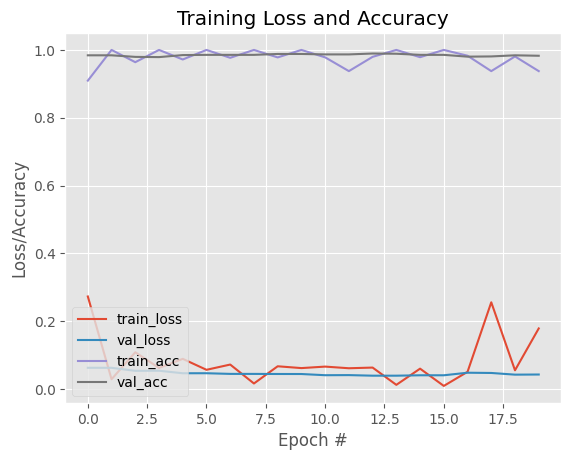

In [ ]:
N = EPOCHS
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), H.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, N), H.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")
plt.savefig("plot.png")